
## Abstract
In this project, we deal with the problem of detecting whether a person you are talking to on the phone has placed you on speakerphone or not. We run a series of experiments on data collected via speakerphone and non-speakerphone calls. We show that when background noise is isolated from speech, we are able to perform this detection with high accuracy, but the same models do not work when speech is involved. We conclude that the way forward for this problem is to segment out audio regions where the person is not talking, and run the speakerphone detection on these regions. 

## Introduction
Detecting whether or not you are placed on speakerphone is a challenging and fun problem. Its use cases can range from relatively innocent -- this can serve as a clue for when you are being prank-called-- to perhaps more serious, in the cases of kidnapping, etc. In fact, this [Reddit post](https://www.reddit.com/r/signal/comments/khzrii/speaker_phone_indicator_during_calls/) has a request for such a feature. 

Surprisingly, we find almost no work done has been done on this problem. 

However, if one looks at a broader problem of when one inadvertently reveals information that they don't mean to reveal about themselves in audio and video contexts, there are several interesting works. To list a couple:

1. In _"A Practical Deep Learning-Based Acoustic Side Channel Attack on Keyboards"(1)_, researchers are able to predict what is being typed by the audio emited by the typing via a Zoom call. 
2. In _"The visual microphone: Passive recovery of sound from video" (2)_, researchers are able to detect audio being played from vibrations of objects in the same room. 

For the speakerphone problem, our approach is to collect data via speakerphone and non-speakerphone, and see if a machine learning model can learn the difference to then predict this. 

## Data Collection

From a basic survey, it seems:

1. Phone call datasets with and without speaker are not available. The usual reason to collect such data is detection of various speech properties, which is different from our usecase. 
2. Another idea would have been to collect video datasets and use the existence or non-existence of a headset to conclude whether the audio is on speaker or not. However, even such datasets are not readily available. 

Thus, we had to collect data ourselves. We used a Google Pixel 4a Android phone, and made phone calls to our laptop using Google Voice. We collected samples with and without speakerphone on. We then converted these mp3 files to [Mel-frequency cepstral coefficients(MFCC's)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) which is a standard way of obtaining features from audio files. 

In [26]:
from pydub import AudioSegment
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [27]:
def mp3_to_vectors(mp3_path, segment_length_ms=3000):
    # Load the MP3 file
    audio = AudioSegment.from_mp3(mp3_path)

    # Split the audio into one-minute segments
    segments = [audio[i:i+segment_length_ms] for i in range(0, len(audio), segment_length_ms)]

    # Process each segment into vectors
    vectors = []
    for segment in segments[:-1]:
        # Export segment to a temporary WAV file
        segment.export("temp.wav", format="wav")

        # Load the segment using librosa
        y, sr = librosa.load("temp.wav", sr=None)

        # Extract features (e.g., MFCCs)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)

        # Flatten the mfccs
        mfcc = mfcc.flatten()
        
        # Append the features to the vectors list
        vectors.append(mfcc)

    return np.array(vectors)


In [28]:
# Loading data from mp3 files

def create_dataset(speaker_path, nonspeaker_path):

    #Ignores first 30 seconds of recording
    vectors_class_0 = mp3_to_vectors(nonspeaker_path)[10:]
    vectors_class_1 = mp3_to_vectors(speaker_path)[10:]

    labels_class_0 = np.zeros(len(vectors_class_0))
    labels_class_1 = np.ones(len(vectors_class_1))

    vectors_unshuffled = np.concatenate((vectors_class_0, vectors_class_1))
    labels_unshuffled = np.concatenate((labels_class_0, labels_class_1))

    indices = np.arange(len(vectors_unshuffled))
    np.random.shuffle(indices)
    vectors = vectors_unshuffled[indices]
    labels = labels_unshuffled[indices]

    return (vectors, labels)

In [29]:
def model_and_accuracy(vectors, labels):
    X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size = 0.2, random_state = 23)
    classifier = SVC()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return (classifier, accuracy)

In [30]:
def lda_model_and_accuracy(vectors, labels):
    X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size = 0.2, random_state = 23)
    lda = LDA()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return (lda, accuracy)

## Experiments
First, we test our set up (conversion from MP3 files to MFCC's, creating the dataset, and running a basic SVM classifier on some dummy data. As expected, when both class-labels are from the same MP3 file, the classifer performs horribly (Accuracy shown below:)

In [31]:
# Experiment 1 
# With the dummy dataset (both same classes)
speaker_path = "recording_test.mp3"
nonspeaker_path = "recording_test.mp3"

vectors, labels = create_dataset(speaker_path, nonspeaker_path)
model, accuracy = model_and_accuracy(vectors, labels)

print(accuracy)


0.25


And when the two classes are different songs, a simple classifier performs well:

In [9]:
# Experiment 2
# With 2 obviously different songs
speaker_path = "celticwoman.mp3"
nonspeaker_path = "gladyoureviltoo.mp3"

vectors, labels = create_dataset(speaker_path, nonspeaker_path)
model, accuracy = model_and_accuracy(vectors, labels)

print(accuracy)

0.9743589743589743


### Experiment 1
We play a recording of a Youtube video with and without speaker. This is about 7 minutes long, divided into segments of 3 seconds. We then run a basic SVM classifier on this data to get the following accuracy:

In [11]:
# Experiment 3
# Two audio clips of the same video, one recorded on speaker, one recorded without speaker

speaker_path = "with_speaker_youtube_video.mp3"
nonspeaker_path = "no_speaker_youtube_video.mp3"

vectors, labels = create_dataset(speaker_path, nonspeaker_path)
model, accuracy = model_and_accuracy(vectors, labels)

print(accuracy)

0.7857142857142857


The accuracy is okay, but still not great for 2-class classification. We try to plot the principal components of both the speakerphone and non-speakerphone data points, and we find that there does not seem to be much separation as shown below. It seems like the speech of the Youtube video is interfering too much with the detection of speakerphone/ non-speakerphone. 

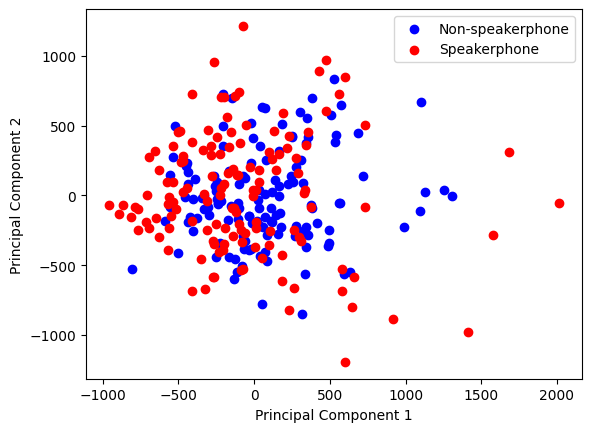

In [12]:
# Experiment 4
# PCA visualization of Non-speaker and Speaker data (after experiment 3)
vectors_class_0 = vectors[labels == 0]
vectors_class_1 = vectors[labels == 1]

pca = PCA(n_components = 2)
reduced_data = pca.fit_transform(np.vstack((vectors_class_0, vectors_class_1)))
plt.scatter(reduced_data[:len(vectors_class_0), 0], reduced_data[:len(vectors_class_0), 1], color='blue', label='Non-speakerphone')
plt.scatter(reduced_data[len(vectors_class_1):, 0], reduced_data[len(vectors_class_1):, 1], color='red', label='Speakerphone')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### Experiment 2
We try another strategy. This time we record only the background noise of a room both on speaker and without speaker. While the simple classifier still performs badly (accuracy shown below) when we plot the principal components, they seem to be further apart from each other. 

In [32]:
# Experiment 5 - With and without speaker, only noise
speaker_path = "with_speaker_noise.mp3"
nonspeaker_path = "no_speaker_noise.mp3"

vectors, labels = create_dataset(speaker_path, nonspeaker_path)
model, accuracy = model_and_accuracy(vectors, labels)

print(accuracy)

0.5853658536585366


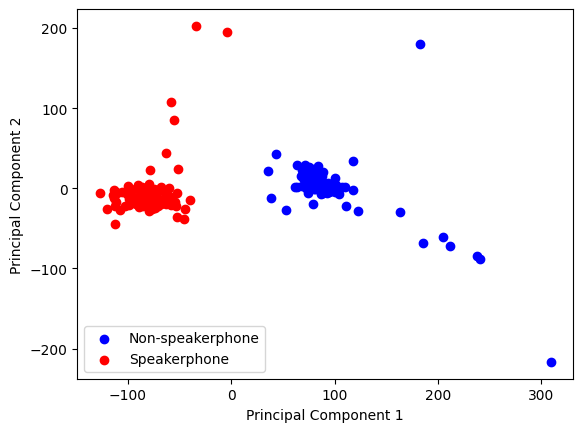

In [33]:
# Experiment 6
# PCA visualization of Non-speaker and Speaker data (after experiment 5)
vectors_class_0 = vectors[labels == 0]
vectors_class_1 = vectors[labels == 1]

pca = PCA(n_components = 2)
reduced_data = pca.fit_transform(np.vstack((vectors_class_0, vectors_class_1)))
plt.scatter(reduced_data[:len(vectors_class_0), 0], reduced_data[:len(vectors_class_0), 1], color='blue', label='Non-speakerphone')
plt.scatter(reduced_data[len(vectors_class_1):, 0], reduced_data[len(vectors_class_1):, 1], color='red', label='Speakerphone')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

The previous samples were taken with a 3 hour gap. We confirm that the same thing holds when the samples are taken at nearly the same time (definitely the same background noise in both speakerphone/ nonspeakerphone cases). Again the SVM accuracy is bad, but the principal components plot makes us hopeful. 

In [34]:
# Experiment 7 - with and without speaker - only noise 
# In same time frame (Samples in Experiment 5 were taken 3 hours apart)

speaker_path = "with_speaker_noise.mp3"
nonspeaker_path = "no_speaker_noise_same_env.mp3"

vectors, labels = create_dataset(speaker_path, nonspeaker_path)
model, accuracy = model_and_accuracy(vectors, labels)

print(accuracy)

0.391304347826087


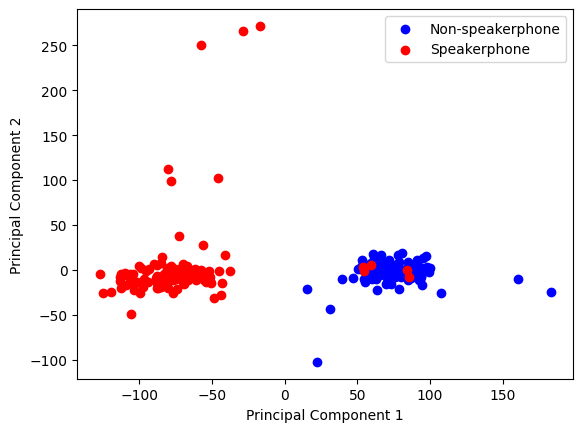

In [35]:
# Experiment 8
# PCA visualization of Non-speaker and Speaker data (after experiment 7)
vectors_class_0 = vectors[labels == 0]
vectors_class_1 = vectors[labels == 1]

pca = PCA(n_components = 2)
reduced_data = pca.fit_transform(np.vstack((vectors_class_0, vectors_class_1)))
plt.scatter(reduced_data[:len(vectors_class_0), 0], reduced_data[:len(vectors_class_0), 1], color='blue', label='Non-speakerphone')
plt.scatter(reduced_data[len(vectors_class_1):, 0], reduced_data[len(vectors_class_1):, 1], color='red', label='Speakerphone')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### Experiment 3
Looking at the above plot, it seems like a Linear Discriminant Analysis (LDA) classifier would perform well. Indeed, it turns out to be the case, and the above performs well on test data with excellent accuracy:

In [36]:
# Experiment 9 - Trying to classify the above with LDA. 
speaker_path = "with_speaker_noise.mp3"
nonspeaker_path = "no_speaker_noise_same_env.mp3"

vectors, labels = create_dataset(speaker_path, nonspeaker_path)
model, accuracy = lda_model_and_accuracy(vectors, labels)

print(accuracy)

1.0


### Experiment 4
Now that we have a trained model from the previous data, we try to apply this same model with speech. I record two speech segments in the same room where the background noise was obtained with and without speakerphone, and run the classifier. However, this time the accuracy is horrible:


In [18]:
# Experiment 10 - does a model trained on noise work well when speech is added?
# Using the above model to classify speaker and non speaker when speech is involved
speaker_path = "with_speaker_speech.mp3"
nonspeaker_path = "no_speaker_speech.mp3"

X_test, y_test = create_dataset(speaker_path, nonspeaker_path)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5384615384615384


### Experiment 5
We try to study what happens when the speech is added back. We plot the values after LDA for all 4 classes of noise and speech, with and without speakerphone. There is a clear separation between the noise classes (speakerphone and without). But the same separator clearly puts all the speech samples in the speakerphone category. 

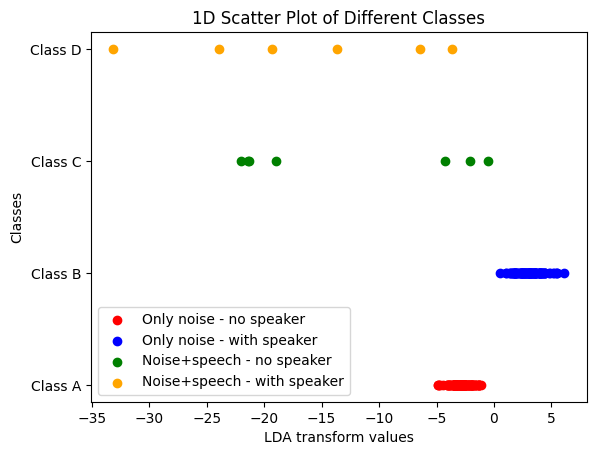

In [20]:
class_A_values = model.transform(vectors[labels == 0])
class_B_values = model.transform(vectors[labels == 1])
class_C_values = model.transform(X_test[y_test == 0])
class_D_values = model.transform(X_test[y_test == 1])

# Assigning a unique y-value (category) for each class
y_A = [1] * len(class_A_values)
y_B = [2] * len(class_B_values)
y_C = [3] * len(class_C_values)
y_D = [4] * len(class_D_values)

# Creating the scatter plot
plt.scatter(class_A_values, y_A, color='red', label='Only noise - no speaker')
plt.scatter(class_B_values, y_B, color='blue', label='Only noise - with speaker')
plt.scatter(class_C_values, y_C, color='green', label='Noise+speech - no speaker')
plt.scatter(class_D_values, y_D, color='orange', label='Noise+speech - with speaker')

# Adding labels and title
plt.xlabel('LDA transform values')
plt.ylabel('Classes')
plt.yticks([1, 2, 3, 4], ['Class A', 'Class B', 'Class C', 'Class D'])
plt.title('1D Scatter Plot of Different Classes')

# Adding legend
plt.legend()

# Show the plot
plt.show()

## Conclusion
It seems that the best way forward is to segment out the speech portion from the audio obtained from the speakerphone and then apply this analysis. The above experiments have been done on a small number of data samples (around 100), and without much generalization (all data collected in the same room). Thus, both the segmentation and generalization are immediate next steps from this project. From these small experiments, it does seem like machine learning can be used to do this detection, but will require more work and fine tuning. All of the experiments above, and all the data collected are clearly recorded in the following github repository: [speakerphone_project](https://github.com/Tinkidinki/speakerphone_project).

In [ ]:
speaker_path = "with_speaker_speech.mp3"
nonspeaker_path = "no_speaker_speech.mp3"

X_test, y_test = create_dataset(speaker_path, nonspeaker_path)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

## References

1. J. Harrison, E. Toreini and M. Mehrnezhad, "A Practical Deep Learning-Based Acoustic Side Channel Attack on Keyboards," 2023 IEEE European Symposium on Security and Privacy Workshops (EuroS&PW), Delft, Netherlands, 2023, pp. 270-280, doi: 10.1109/EuroSPW59978.2023.00034.
2. Davis, Abe & Rubinstein, Michael & Wadhwa, Neal & Mysore, Gautham & Freeman, William & Durand, Fredo. (2014). The visual microphone: Passive recovery of sound from video. 
